<a href="https://colab.research.google.com/github/rebeccadimatteo/FitDiary_FIA/blob/main/regressioneLineare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressione lineare multipla

## Ottenimento del dataset

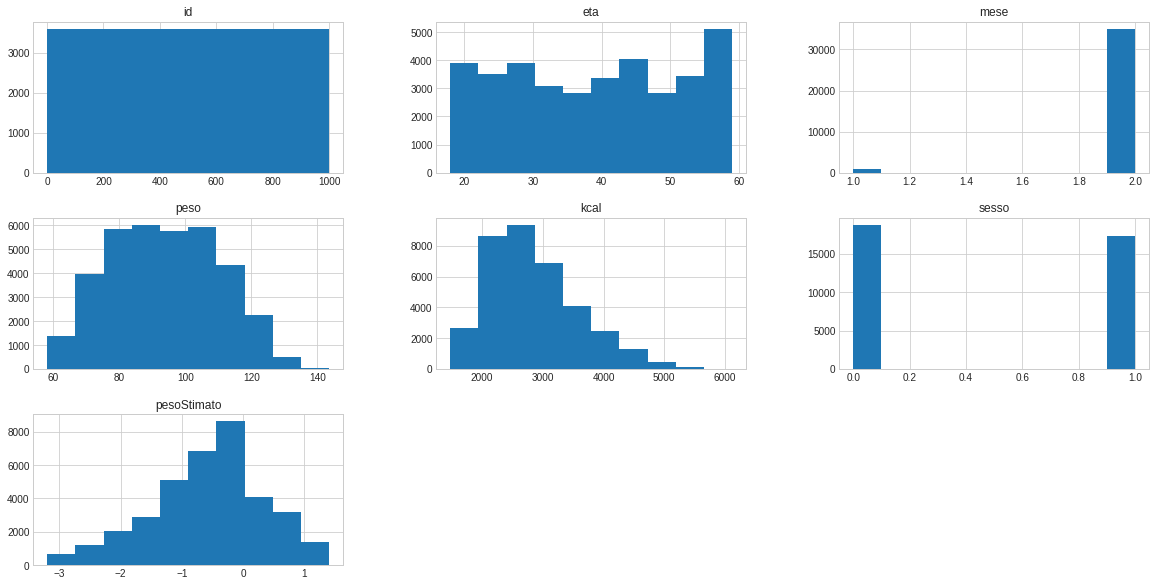

,id,eta,mese,peso,kcal,sesso,pesoStimato
0,1,46,1,67.00000,2061,0,-0.438622
1,1,46,2,67.43862,1537,0,-1.277814
2,1,46,2,68.71644,3173,0,0.399622
3,1,46,2,68.31682,2684,0,0.281297
4,1,46,2,68.03552,1568,0,-1.225765


In [89]:
import pandas as pd
import os
from six.moves import urllib

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/FitDiary_FIA/master/dataset.csv"

def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df=df[["id", "eta", "mese", "peso", "kcal", "sesso", "pesoStimato"]]
df.hist()
plt.show()
df.head(5)

## 1)DataCleaning

### 1.1) Descrizione del dataset

In [90]:
df.describe()

,id,eta,mese,peso,kcal,sesso,pesoStimato
count,36000.000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,500.500,38.973000,1.972222,93.960686,2854.008639,0.481000,-0.577729
std,288.679,12.283911,0.164338,16.473259,739.296984,0.499646,0.931751
min,1.000,18.000000,1.000000,58.159405,1476.000000,0.000000,-3.196676
25%,250.750,28.000000,2.000000,80.624093,2294.000000,0.000000,-1.165279
50%,500.500,39.000000,2.000000,93.661348,2725.000000,0.000000,-0.487886
75%,750.250,49.000000,2.000000,106.744870,3285.250000,1.000000,0.000000
max,1000.000,59.000000,2.000000,143.593690,6117.000000,1.000000,1.402835


### 1.2) Verifica valori null nel dataset

In [91]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [92]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

###1.4) Data Plot

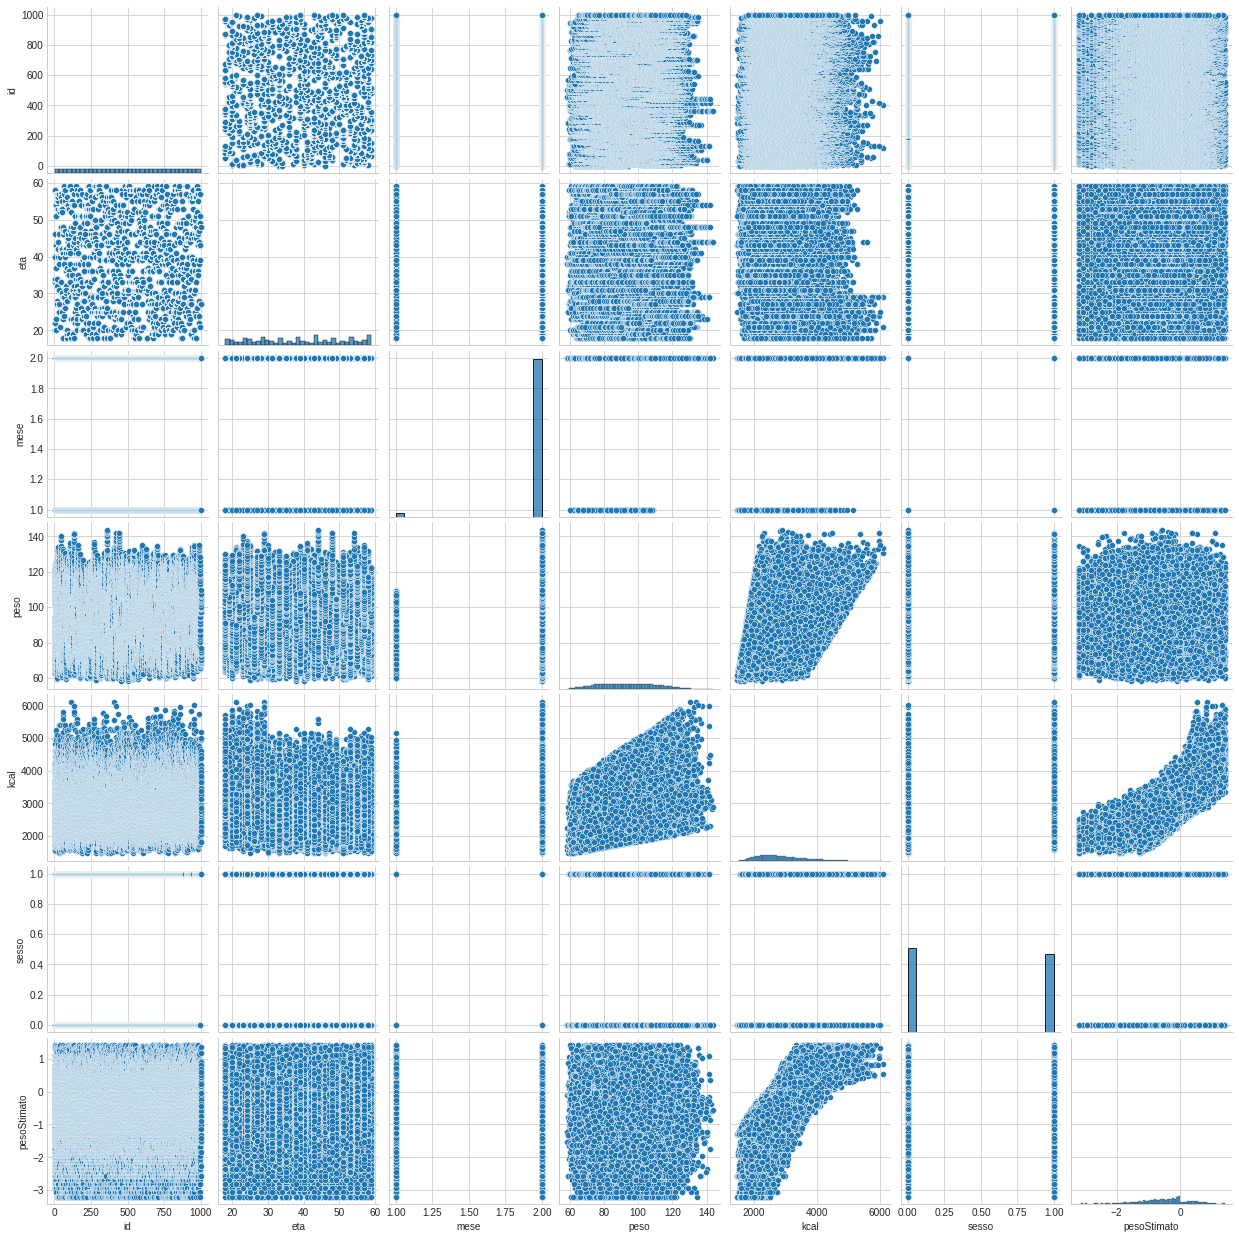

In [93]:
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (20,10)

sb.pairplot(df)

plt.savefig('pairplor.png')

###1.5) Plot Linearità

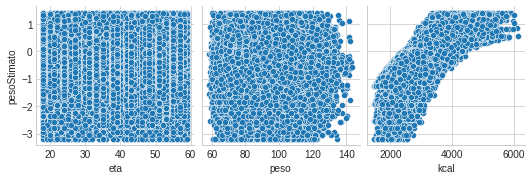

In [105]:
sb.pairplot(df,x_vars=["eta", "peso", "kcal"], y_vars=["pesoStimato"])

plt.savefig('linearPlot.png')

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) K-fold, Repeated K-fold, SelectKBest

In [103]:
from re import M
from sklearn.model_selection import RepeatedKFold, KFold
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import copy

#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse,model):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse
    self.model=model
  
  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

def generateModel(alg, scaler, model):
  #array di metriche (MAE,MSE,RMSE)
  metrics1=[]
  #generazione n_split test/trainig sets
  for train_index,test_index in alg.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Z-Scaling
    #feature Scaling StandardScaler sui traing test
    
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    #applicazione feature scaling kBest su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)
    #training dell'algroitmo di regressione lineare sui training set (z-score Norm.)
    regress.fit(X_train_z,y_train)
    #validazione modello
    #applicazione predizione sui testSet
    y_pred = regress.predict(X_test_z)
    modelCopy = copy.copy(regress)
    #calcolo metriche predizione
    metrics1.append(Metrics1(metrics.mean_absolute_error(y_test,y_pred),
                            metrics.mean_squared_error(y_test,y_pred),
                            np.sqrt(metrics.mean_squared_error(y_test,y_pred)),
                            modelCopy))
    
  #array medie degli errori kf
  meanMAE=[]
  meanMSE=[]
  meanRMSE=[]

  #calcolo singole medie degli errori kf
  for m in metrics1:
    meanMAE.append(m.mae)
    meanMSE.append(m.mse)
    meanRMSE.append(m.rmse)

  print("meanMAE=",np.mean(meanMAE))    
  print("meanMSE=",np.mean(meanMSE))    
  print("meanRMSE=",np.mean(meanRMSE))

#istanziazione dell'algoritmo di regressione lineare
regress=LinearRegression()

#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop('pesoStimato',1)
y=df.pesoStimato

#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#Kf con non k gruppo
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con non k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select= SelectKBest(f_regression, k=4)

print("\nLinear Regression - ZScore Normalization - KF")
generateModel(kf, StandardScaler(), regress)
print("\nLinear Regression - ZScore Normalization - RKF")
generateModel(kf, StandardScaler(), regress)
print("\nLinear Regression - MinMax Normalization - KF")
generateModel(kf, MinMaxScaler(), regress)
print("\nLinear Regression - MinMax Normalization - RKF")
generateModel(kf, MinMaxScaler(), regress)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



Linear Regression - ZScore Normalization - KF
meanMAE= 0.362287358485174
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637

Linear Regression - ZScore Normalization - RKF
meanMAE= 0.362287358485174
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637

Linear Regression - MinMax Normalization - KF
meanMAE= 0.36228735848517396
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637

Linear Regression - MinMax Normalization - RKF
meanMAE= 0.36228735848517396
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637
